## Silhouette Methods

<br>

<div style="border: 1px solid #ccc; padding: 15px; background-color: #fdfdfd ; border-radius: 5px;">

### *Silhouette Score*

The Silhouette score evaluates clustering quality by comparing intra-cluster cohesion and inter-cluster separation (how similar each point $x_i$ is to its own cluster $C_j$ compared to other clusters $C_{d\ne j}$).  
Given a data point $x_i \in C_j$ , the silhouette score $s(x_i)$ is defined as:  

$$
s(x_i) = \frac{b(x_i) - a(x_i)}{\max{ \{a(x_i), \ b(x_i)} \} } \
$$

where $a(x_i)$ (**Intra-Cluster Distance**) measures the average distance between $x_i$ and other points in its own cluster $C_j$ and $b(x_i)$ (**Inter Cluster Distance**) is the minimum average distance to any other cluster $C_d$.

$$
a(x_i) = \frac{1}{|C_j|-1}  \sum_{x_k \in C_j, k \ne i}{d(x_i, x_k)} \ , \quad b(x_i) = \min_{d \ne j}\Bigl\{{\frac{1}{|C_d|} \sum_{x_k \in C_d}{d(x_i,x_k)}}\Bigr\}
$$
 

<div style="border: 1px solid #ccc; padding: 15px; background-color: #fdfdfd ; border-radius: 5px;">

### *Silhouette Aggregation*

To generalize silhouette analysis across an entire dataset ($n$ : number of data points, $ \ k$ : number of clusters) , we use two primary aggregation methods:  

* **Micro-average Silhouette score:** Averages silhouette scores across all individual points.
$$
S_\text{micro} = \frac{1}{n} \sum_{i=1}^{n}{s(x_i)}
$$
 Suitable when evaluating clustering consistency at the individual level, where each data point contributes equally to the final score.  
   
    <br>
    
* **Macro-average Silhouette score:** Averages the mean silhouette per cluster.
$$
S_\text{macro} = \frac{1}{k} \sum_{j=1}^{k}\frac{1}{|C_j|}\sum_{x_i \in C_j}{s(x_i)}
$$
 Suitable when ensuring equal importance to all clusters, regardless of size, preventing large clusters from dominating the score.
    
These aggregation methods provide complementary insights, with $S_\text{micro}$ emphasizing point-level clustering quality and $S_\text{macro}$ focusing on per-cluster clustering quality.

<div style="border: 1px solid #ccc; padding: 15px; background-color: #fdfdfd ; border-radius: 5px;">

### *Silhouette Approximation*

For large datasets, exact silhouette computation can be computationally expensive ~ $O(n^2$) . Instead, an approximation of silhouette (option: `approximation=True`) can be used in the following methods, based on the cluster centroids $(\mu_j)$ and the sum of squares within clusters $(SS_j = \sum_{x_i \in C_j}{\|x_i - \mu_j\|^2})$ to reduce the computational cost approximately to $O(n\cdot k)$.

* **Approximate Intra-Cluster Distance ($x_i \in C_j$):**
$$
\tilde a(x_i) = \sqrt{\frac{|C_j|\cdot \|x_i - \mu_j \|^2 + SS_j}{|C_j|-1}}
$$
        <br>
* **Approximate Inter-Cluster Distance ($x_i \in C_j$):**
$$
\tilde b(x_i) = \min_{d\ne j}\Bigl\{\sqrt{\|x_i-\mu_d\|^2 + \frac{SS_d}{|C_d|}} \ \Bigr\}
$$
        <br>
* **Approximate Silhouette score ($x_i \in C_j$):**
$$
\tilde s(x_i) = \frac{\tilde b(x_i) - \tilde a(x_i)}{\max{ \{\tilde a(x_i), \ \tilde b(x_i)} \} } \
$$    

Although we do not compute exact pairwise distances, this method tends to preserve the relative ranking/ordering of silhouette scores across different points and clusters. This is because the intra-cluster approximation captures point-to-centroid distances, weighted by the cluster's spread (sum of squares) and the inter-cluster approximation finds the closest centroid, adjusting for cluster compactness. As a result, while absolute values may slightly differ, the ordering of points based on silhouette scores remains reliably consistent. This makes it effective for:
*   **Choosing the optimal number of clusters (k)**.
*   **Comparing clustering solutions**.
*   **Identifying well-clustered vs. poorly-clustered points**.
  
  

<div style="border: 1px solid #ccc; padding: 15px; background-color: #fdfdfd ; border-radius: 5px;">

### *Appropriate Sampling Strategies*

To enhance computational efficiency while preserving accuracy, we apply different sampling methods based on the aggregation type:
*   **Uniform Sampling** for $S_\text{micro}$.  
Micro-averaging treats each point equally, meaning we need a sample that represents the overall dataset proportionally. Random selection across all points maintains the global distribution of silhouette scores without over-representing or under-representing any specific cluster. This ensures that the estimated $S_\text{micro}$ remains consistent with the full dataset.
  
    <br>
      
*   **Balanced (per cluster) Sampling** for $S_\text{macro}$.  
Macro-averaging gives equal weight to each cluster, so using standard random sampling could bias the result toward larger clusters. Instead, we sample approximately equal numbers of points from each cluster, ensuring that small clusters are fairly represented in the final macro-average calculation. This makes $S_\text{macro}$ robust to cluster size imbalances, maintaining its ability to evaluate overall clustering performance.

---

We present the following methods to compute and analyze silhouette scores, incorporating both exact and approximate computations, as well as micro- and macro-aggregations with appropriate sampling strategies:

*   **`point_silhouettes(X, labels, approximation=False, centers=None)`**

    Computes the **silhouette score for each point** in the dataset.     
    
       
      -  If `approximation=False`, uses **pairwise distances** for exact computation.    
      -  If `approximation=True`, applies the **centroid-based approximation** to reduce complexity.  
      
       <br>

*   **`micro_silhouette(X, labels, approximation=False, centers=None, sample_size=-1, seed=42)`**    
    
      Computes the **micro-average silhouette score**.
      Uses **uniform sampling** when `sample_size` is specified.
  
       <br>

*   **`macro_silhouette(X, labels, approximation=False, centers=None, sample_size=-1, seed=42)`**    
  
      Computes the **macro-average silhouette score**.
      Uses **balanced sampling** when `sample_size` is specified.

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_samples
from scipy.spatial.distance import cdist

def point_silhouettes(X, labels, approximation=False, centers=None):
    """
    Compute the silhouette score for each individual point in the dataset, with an option for approximate computation.

    Parameters:
       - X: array-like, shape (n_samples, n_features)
             The input data.
       - labels: array-like, shape (n_samples,)
                  The cluster labels for each sample.
       - approximation: bool, default=False
                        - If False, computes exact silhouette scores using sklearn's silhouette_samples.
                        - If True, uses an approximate silhouette computation based on centroids and sum of squares.
       - centers: pd.Series, default=None (optional: used only for approximation option)
                  A dictionary mapping cluster labels to their precomputed centroids.
                  - If provided/precomputed, these centroids are used for silhouette approximation.
                  - If None, centroids are computed as the mean of points in each cluster.

    Returns: np.ndarray, shape (n_samples,)
             The silhouette score for each point in X.
    """
    labels = np.asarray(labels)

    # Exact silhouette computation (approximation=False)
    if not approximation:
        return silhouette_samples(X, labels=labels)

    # Approximation (approximation=True)
    # Ensure each cluster has a centroid

    # Compute approximate centers (average of points) if centers not provided
    if centers is None:
        unique_labels = np.unique(labels)
        centers = pd.Series({cl: np.mean(X[labels == cl], axis=0) for cl in unique_labels})

    if hasattr(centers, 'index'):
        unique_labels = np.unique(labels)
        for cl in unique_labels:
            if cl not in centers.index:
                # If centroid not present, compute it as the mean of its cluster's points
                centers.at[cl] = np.mean(X[labels == cl], axis=0).tolist()
        centers = centers.sort_index()
        clusters = centers.index.to_numpy()
        mapping = {c: i for i, c in enumerate(clusters)}
        inv = np.array([mapping[label] for label in labels])
    else:
        # If centers a simple array-like, assume labels 0-based
        clusters = np.arange(len(centers))
        inv = labels

    k = len(clusters)
    n = X.shape[0]

    # Convert centers to a NumPy array
    centers_arr = np.array(centers.tolist())

    # Compute differences and squared distances between points and their assigned centroids
    diffs = X - centers_arr[inv]         # Shape: (n, d)
    dists_sq = np.sum(diffs**2, axis=1)    # Shape: (n,)

    # Compute per-cluster counts and within-cluster sum-of-squares (SS)
    counts = np.bincount(inv, minlength=k)
    SS_arr = np.bincount(inv, weights=dists_sq, minlength=k)

    # Compute full distance matrix from every point to every centroid
    D = cdist(X, centers_arr, metric='euclidean')
    
    # Extract for each point the distance to its own centroid
    D_diag = D[np.arange(n), inv]

    # For each point, get the count and SS corresponding to its cluster
    count_vec = counts[inv]
    ss_vec = SS_arr[inv]

    # Compute approximate intra-cluster distances a(x_i).
    a_vals = np.where(
        count_vec > 1,
        np.sqrt((count_vec * (D_diag ** 2) + ss_vec) / (count_vec - 1)),
        D_diag
    )

    # Compute candidate distances for b(x_i)
    # candidate_matrix[i, j] = sqrt( D[i, j]^2 + (SS_arr[j] / counts[j]) )
    cluster_term = SS_arr / np.maximum(counts, 1e-6)  # per-cluster term
    candidate_matrix = np.sqrt(D**2 + cluster_term.reshape(1, k))
    candidate_matrix[np.arange(n), inv] = np.inf  # Exclude own cluster

    # b(x_i) is the minimum candidate value
    b_vals = np.min(candidate_matrix, axis=1)
    
    # Maximum of a(x_i), b(x_i)
    max_ab = np.maximum(np.maximum(a_vals, b_vals), 1e-6) # Avoid zero division

    # Compute approximate silhouette scores for each point.
    silhouette_scores = (b_vals - a_vals) / max_ab
    
    return silhouette_scores

def micro_silhouette(X, labels, approximation=False, centers=None, sample_size=-1, seed=42):
    """
    Compute the micro-average silhouette score, the overall mean silhouette score across all points.

    Parameters:
       - X: array-like, shape (n_samples, n_features)
            The input dataset.
       - labels: array-like, shape (n_samples,)
                 Cluster labels for each sample.
       - approximation: bool, default=False
                        - If False, computes exact silhouette scores using sklearn's silhouette_samples.
                        - If True, uses an approximate silhouette computation based on centroids and sum of squares.
       - centers: dict or pd.Series, default=None (optional)
                  A dictionary mapping cluster labels to their precomputed centroids.
                  - If provided, these centroids are used for silhouette approximation.
                  - If None, centroids are computed as the mean of points in each cluster.
       - sample_size: int or float, default=-1
                      Number of points to sample uniformly (for micro-average silhouette score)
                      - If sample_size == -1: no sampling.
                      - If 0 <= sample_size <= 1: sample that fraction of the data.
                      - If sample_size > 1: sample that exact number of points.
       - seed: int, default=42
               Random seed for reproducibility, used when sampling is enabled (sample_size!=-1).

    Returns: float
             The micro-average silhouette score.
    """
    # If sampling is not enabled (sample_size=-1)
    if sample_size == -1:
        point_scores = point_silhouettes(X, labels, approximation=approximation, centers=centers)
    else: # If sampling is enabled (sample_size != -1)
        # Perform uniform sampling, as this sampling strategy aligns with micro-average silhouette score nature
        np.random.seed(seed)
        n_samples=len(X)
        labels = np.array(labels)
        if 0 <= sample_size <= 1: # sample_size as a fraction of the dataset
            size=int(np.ceil(sample_size*n_samples))
        elif sample_size > 1: # sample_size as the exact number of points to sample
            size=int(sample_size)
        else:
            raise ValueError(
                '"sample_size" must be -1, a fraction (between 0 and 1), or an exact number of data points'
            )
        if size == 0:
            raise ValueError("Sample size computed as 0. Increase sample_size or adjust the parameters.")

        indices=np.random.choice(n_samples, size=size, replace=False)

        num_sampled=len(indices)
        num_clusters=len(np.unique(labels[indices]))
        if num_sampled <= num_clusters:
            raise ValueError(
                  f"Uniform Sampling produced only {num_sampled} samples for {num_clusters} clusters. "
                  "Increase sample_size or adjust the sampling strategy.")

        # Silhouette scores computation on the sampled dataset
        point_scores = point_silhouettes(X[indices], labels[indices], approximation=approximation, centers=centers)

    return np.mean(point_scores)  # Simple mean across all points (micro)

def macro_silhouette(X, labels, approximation=False, centers=None, sample_size=-1, seed=42):
    """
    Compute the macro-average silhouette score, the mean of per-cluster silhouette scores.

    Parameters:
       - X: array-like, shape (n_samples, n_features)
            The input dataset.
       - labels: array-like, shape (n_samples,)
                 Cluster labels for each sample.
       - approximation: bool, default=False
                        - If False, computes exact silhouette scores using sklearn's silhouette_samples.
                        - If True, uses an approximate silhouette computation based on centroids and sum of squares.
       - centers: dict or pd.Series, default=None (optional)
                  A dictionary mapping cluster labels to their precomputed centroids.
                  - If provided, these centroids are used for silhouette approximation.
                  - If None, centroids are computed as the mean of points in each cluster.
       - sample_size: int or float, default=-1
                      Number of points to sample in a balanced way (for macro-average silhouette score)
                      - If sample_size == -1: no sampling.
                      - If 0 <= sample_size <= 1: sample that fraction of the data.
                      - If sample_size > 1: sample that exact number of points.
       - seed: int, default=42
               Random seed for reproducibility, used when sampling is enabled (sample_size!=-1).

    Returns:  float
              The macro-average silhouette score.
    """
    # sampling is not enabled (sample_size=-1)
    if sample_size == -1:
        point_scores = point_silhouettes(X, labels, approximation=approximation, centers=centers)
    else: # If sampling is enabled (sample_size != -1)
        # Perform balanced sampling, as this sampling strategy aligns with macro-average silhouette score nature
        np.random.seed(seed)
        n_samples=len(X)
        labels = np.array(labels)
        if 0 <= sample_size <= 1: # sample_size as a fraction of the dataset
            size=int(np.ceil(sample_size*n_samples))
        elif sample_size > 1: # sample_size as the exact number of points to sample
            size=int(sample_size)
        else:
            raise ValueError(
                '"sample_size" must be -1, a fraction (between 0 and 1), or an exact number of data points'
            )
        if size == 0:
            raise ValueError("Sample size computed as 0. Increase sample_size or adjust the parameters.")

        unique_clusters = np.unique(labels)
        samples_per_cluster = max(1, size // len(unique_clusters))
        indices_list = []
        for cluster_label in unique_clusters:
            cluster_indices = np.where(labels == cluster_label)[0]
            if len(cluster_indices) == 0:
                continue
            chosen_size = min(len(cluster_indices), samples_per_cluster)
            if chosen_size == 0:
                continue
            chosen_indices = np.random.choice(cluster_indices, size=chosen_size, replace=False)
            indices_list.append(chosen_indices)
        if indices_list:
            indices = np.concatenate(indices_list)
        else:
            indices = np.array([], dtype=int)
        if indices.shape[0] <= len(unique_clusters):
            raise ValueError(
                f"Balanced Sampling produced only {indices.shape[0]} samples for {len(unique_clusters)} clusters. "
                "Increase sample_size or adjust the sampling strategy.")

        # Retain the sampled dataset and labels array
        X = X[indices]
        labels = labels[indices]
        point_scores = point_silhouettes(X, labels, approximation=approximation, centers=centers)

    # Compute per-cluster mean silhouette scores
    unique_clusters = np.unique(labels)
    cluster_means = []

    for cluster in unique_clusters:
        cluster_scores = point_scores[labels == cluster]  # Get silhouette scores for the cluster
        cluster_means.append(cluster_scores.mean())  # Compute mean silhouette for this cluster

    return np.mean(cluster_means)  # Mean across all clusters (macro)



---





### Impact of Sampling and Approximation on Silhouette Computation

In [2]:
import time
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Synthetic data
X, _ = make_blobs(n_samples=100000, centers=5, random_state=42)

# Clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init="auto")
labels = kmeans.fit_predict(X)

# Cluster centers
centers = {i: kmeans.cluster_centers_[i] for i in range(5)}
centers = pd.Series(centers)

# Benchmarking
results = []
for sample_s in [-1, 0.7]:  # -1: no Sampling, 0.7: sampling (70% of the dataset)
    for approx in [False, True]:  # False: no approximation, True: approximation
        start = time.time()
        micro = micro_silhouette(X, labels, approximation=approx, centers=centers, sample_size=sample_s)
        macro = macro_silhouette(X, labels, approximation=approx, centers=centers, sample_size=sample_s)
        elapsed = time.time() - start

        approx_symbol = "Yes" if approx else "No"
        sample_symbol = "Yes" if sample_s != -1 else "No"

        results.append([sample_symbol, approx_symbol, micro, macro, elapsed])

df_results = pd.DataFrame(results, columns=["Sampling", "Approximation", "Micro-Silhouette", "Macro-Silhouette", "Time (s)"])
df_results.set_index(["Sampling", "Approximation"], inplace=True)
display(df_results)

Micro-Silhouette  Macro-Silhouette    Time (s)
Sampling Approximation                                                
No       No                     0.667704          0.667693  197.558816
         Yes                    0.644024          0.644012    0.113577
Yes      No                     0.667539          0.668501  103.447666
         Yes                    0.643840          0.644726    0.062839



---



### Silhouette scores (with/without sampling , with/without approximation) across k (number of clusters)

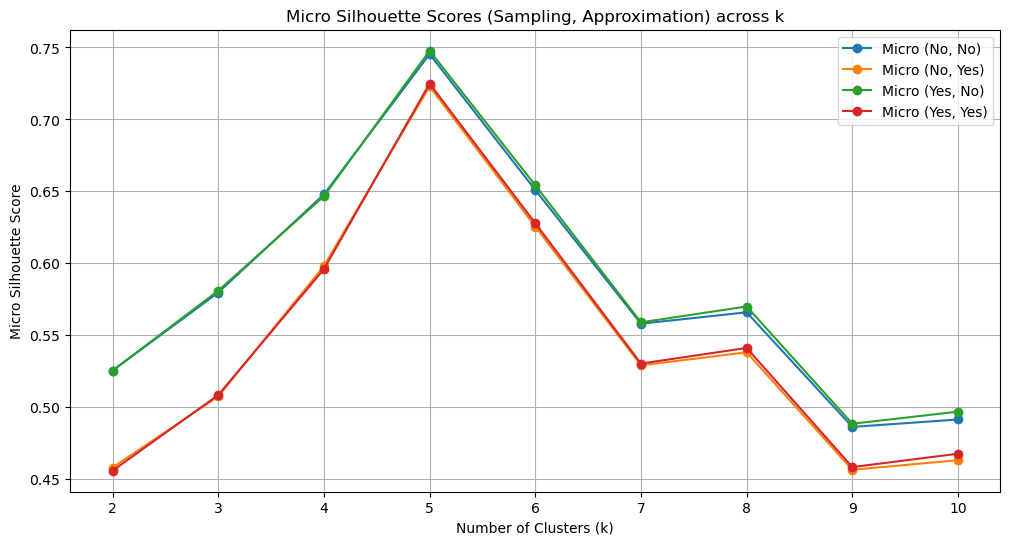

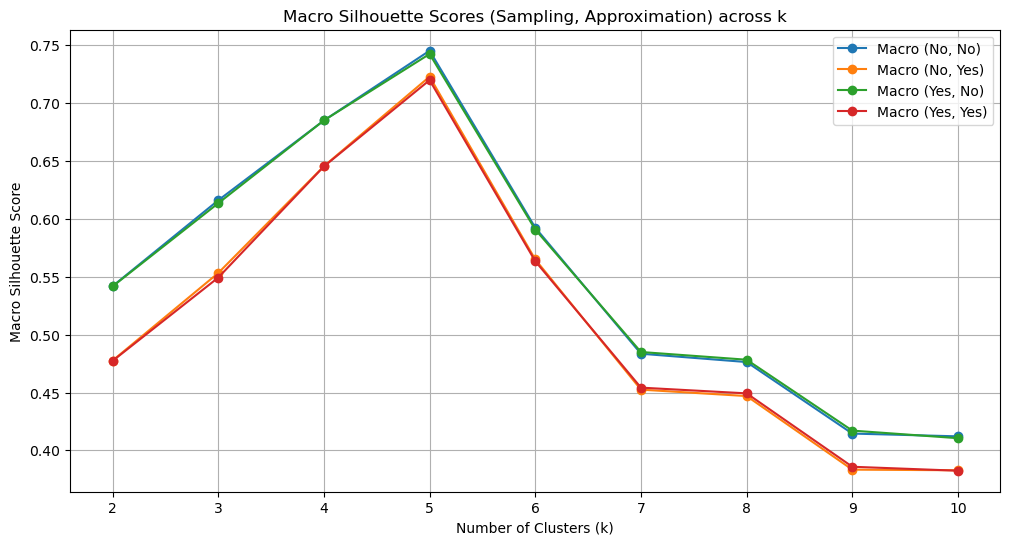

In [3]:
X, _ = make_blobs(n_samples=3000, centers=5, random_state=70)

k_values = range(2, 11)

results = []

# Loop over different k values
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init = "auto")
    labels = kmeans.fit_predict(X)
    centers = {i: kmeans.cluster_centers_[i] for i in range(k)}
    centers = pd.Series(centers)

    for sample_s in [-1, 0.7]:
        for approx in [False, True]:
            start = time.time()
            micro = micro_silhouette(X, labels, approximation=approx, centers=centers, sample_size=sample_s)
            macro = macro_silhouette(X, labels, approximation=approx, centers=centers, sample_size=sample_s)
            elapsed = time.time() - start

            approx_symbol = "Yes" if approx else "No"
            sample_symbol = "Yes" if sample_s != -1 else "No"

            results.append([k, sample_symbol, approx_symbol, micro, macro, elapsed])

df_results = pd.DataFrame(results, columns=["k",
                                            "Sampling",
                                            "Approximation",
                                            "Micro-Silhouette",
                                            "Macro-Silhouette",
                                            "Time (s)"])

# Micro silhouette scores (with/without sampling , with/without approximation) across k (number of clusters)
plt.figure(figsize=(12, 6))
for (sample_symbol, approx_symbol), group in df_results.groupby(["Sampling", "Approximation"]):
    plt.plot(group["k"], group["Micro-Silhouette"], marker='o', label=f"Micro ({sample_symbol}, {approx_symbol})")

plt.xlabel("Number of Clusters (k)")
plt.ylabel("Micro Silhouette Score")
plt.title("Micro Silhouette Scores (Sampling, Approximation) across k")
plt.legend()
plt.grid(True)
plt.show()

# Macro silhouette scores (with/without sampling , with/without approximation) across k (number of clusters)
plt.figure(figsize=(12, 6))
for (sample_symbol, approx_symbol), group in df_results.groupby(["Sampling", "Approximation"]):
    plt.plot(group["k"], group["Macro-Silhouette"], marker='o', label=f"Macro ({sample_symbol}, {approx_symbol})")

plt.xlabel("Number of Clusters (k)")
plt.ylabel("Macro Silhouette Score")
plt.title("Macro Silhouette Scores (Sampling, Approximation) across k")
plt.legend()
plt.grid(True)
plt.show()



---

